# Implementing a deep neutral network (DNN)

This implementation is inspired by [*Neural Networks and Deep Learning*](http://neuralnetworksanddeeplearning.com/chap1.html) by Michael Nielsen and [*Python Machine Learning*](https://github.com/rasbt/python-machine-learning-book-3rd-edition) by Raschka, Sebastian, and Vahid Mirjalili.

Other references:
- [Backpropagation](https://en.wikipedia.org/wiki/Backpropagation)
- [Neural Networks Demystified [Part 4: Backpropagation]](https://www.youtube.com/watch?v=GlcnxUlrtek)
- [Matrix Differentiation](https://atmos.washington.edu/~dennis/MatrixCalculus.pdf)
- [Matrix Calculus](https://en.wikipedia.org/wiki/Matrix_calculus)
- [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)

In [1]:
import random
import numpy as np

class DeepNeuralNetwork(object):
    def __init__(self, sizes, random_state=1):
        self.num_layers = len(sizes)
        self.sizes = sizes
        np.random.seed(random_state)
        random.seed(np.random.normal(1))
        self.biases = [np.random.normal(loc=0.0, scale=0.01, size=(y,1)) 
                       for y in sizes[1:]]
        self.weights = [np.random.normal(loc=0.0, scale=0.01, size=(y,x)) 
                        for x,y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b,w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def onehotencoding(self, y):
        onehot = np.zeros((y.shape[0], len(np.unique(y))))
        for idx, val in enumerate(y):
            onehot[idx, val] = 1.
        return onehot
    
    def SGD(self, X_train, y_train, epochs, mini_batch_size, eta, 
           X_test=None, y_test=None):
        if X_test is not None: n_test = len(X_test)
        n = len(X_train)
        onehot = self.onehotencoding(y_train)
        self.epochs = epochs
        self.cost = []
        self.train_acc = []
        self.test_acc = []
        for j in range(epochs):
            indices = np.arange(X_train.shape[0])
            random.shuffle(indices)
            X_train = X_train[indices]
            onehot = onehot[indices]
            y_train = y_train[indices]
            for k in range(0,n,mini_batch_size):
                self.update_mini_batch(X_train[k:k+mini_batch_size], onehot[k:k+mini_batch_size], eta)
            train_correct = self.evaluate(X_train, y_train)
            if X_test is not None:
                test_correct = self.evaluate(X_test, y_test)
                self.test_acc.append(test_correct/n_test)
                print('Epoch: %d: Train: %d / %d, Test: %d / %d' 
                      % (j+1, self.evaluate(X_train, y_train), n, self.evaluate(X_test, y_test), n_test))
            else: 
                print('Epoch: %d: Train: %d / %d' 
                      % (j+1, self.evaluate(X_train, y_train), n))
            self.cost.append(sum([self.cost_fn(self.feedforward(x.reshape(x.shape[0],1)),y) 
                                  for x,y in zip(X_train,y_train) ]))
            self.train_acc.append(train_correct/n)
            

    def update_mini_batch(self, X, Y, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in zip(X, Y):
            x = x.reshape(x.shape[0],1)
            y = y.reshape(y.shape[0],1)
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta/len(X))*nw 
                       for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(X))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def evaluate(self, X_test, y_test):
        test_results = [self.feedforward(x.reshape(784,1)) for x in X_test]
        test_results = [np.argmax(x) for x in test_results]
        return sum([int(x==y) for x,y in zip(test_results, y_test)])
    
    def cost_derivative(self, output_activations, y):
        return (output_activations-y)
    
    def cost_fn(self, y, yhat):
        return sum((y-yhat)**2)
    
def sigmoid(z):
    return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

# Example: MNIST dataset

In [2]:
# loading MNIST using scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
y = y.astype(int)
X = ((X/255.) - .5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=10000,
                                                   random_state=123,
                                                   stratify=y)

In [3]:
print('X_train: %d rows, %d columns' % (X_train.shape[0], X_train.shape[1]))

X_train: 60000 rows, 784 columns


In [4]:
print('X_test: %d rows, %d columns' % (X_test.shape[0], X_test.shape[1]))

X_test: 10000 rows, 784 columns


In [5]:
# Show an example of each number
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

<Figure size 640x480 with 10 Axes>

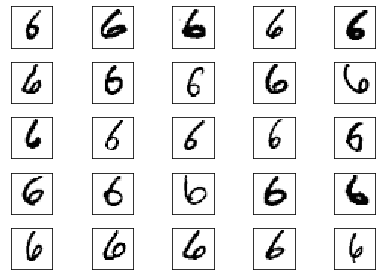

In [6]:
# show some variations of one number
fig, ax = plt.subplots(5,5,sharex=True,sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train==6][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [7]:
dnn = DeepNeuralNetwork(sizes=[28*28, 100, 10])

In [8]:
%%time
dnn.SGD(X_train=X_train, 
        y_train=y_train,
        epochs=20, 
        mini_batch_size=50, 
        eta=0.5,
        X_test=X_test, 
        y_test=y_test)

Epoch: 1: Train: 53932 / 60000, Test: 8959 / 10000
Epoch: 2: Train: 55217 / 60000, Test: 9173 / 10000
Epoch: 3: Train: 55921 / 60000, Test: 9274 / 10000
Epoch: 4: Train: 56369 / 60000, Test: 9347 / 10000
Epoch: 5: Train: 56622 / 60000, Test: 9379 / 10000
Epoch: 6: Train: 56984 / 60000, Test: 9440 / 10000
Epoch: 7: Train: 57275 / 60000, Test: 9482 / 10000
Epoch: 8: Train: 57442 / 60000, Test: 9502 / 10000
Epoch: 9: Train: 57647 / 60000, Test: 9535 / 10000
Epoch: 10: Train: 57678 / 60000, Test: 9553 / 10000
Epoch: 11: Train: 57927 / 60000, Test: 9571 / 10000
Epoch: 12: Train: 57938 / 60000, Test: 9580 / 10000
Epoch: 13: Train: 58115 / 60000, Test: 9603 / 10000
Epoch: 14: Train: 58173 / 60000, Test: 9612 / 10000
Epoch: 15: Train: 58291 / 60000, Test: 9609 / 10000
Epoch: 16: Train: 58263 / 60000, Test: 9621 / 10000
Epoch: 17: Train: 58439 / 60000, Test: 9637 / 10000
Epoch: 18: Train: 58508 / 60000, Test: 9659 / 10000
Epoch: 19: Train: 58493 / 60000, Test: 9648 / 10000
Epoch: 20: Train: 586

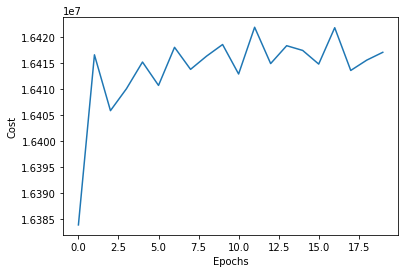

In [9]:
# cost function
import matplotlib.pyplot as plt
plt.plot(range(dnn.epochs), dnn.cost)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

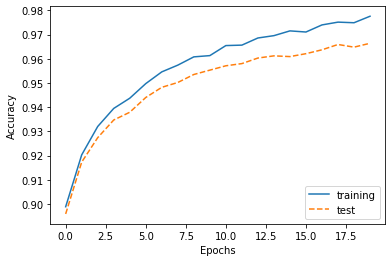

In [10]:
# Training / Testing Accuracy
plt.plot(range(dnn.epochs), dnn.train_acc,
        label='training')
plt.plot(range(dnn.epochs), dnn.test_acc,
        label='test', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()